### Customer Segmentation by Unsupervised Clustering method

### Context
Customer Personality/Segmemtation Analysis is a detailed analysis of a company’s ideal customers. Customer segmentation is the practice of separating customers into groups that reflect similarities among customers in each cluster. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.
Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

In this project, I will be performing an unsupervised clustering of data on the customer's records from a groceries firm's database. 
I will divide customers into segments to optimize the significance of each customer to the business. 

import math
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
from datetime import date
import numpy as np
import pandas as pd 
import os

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

for dirname, _, filenames in os.walk('../Marketing_Analytics/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv('../Marketing_Analytics/dataset/marketing_campaign.csv',sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
print(df.shape)
df.columns

(2240, 29)


Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

The columns can easily be understood from their names.

Columns beginning with Mnt denotes the amount that was spent by the consumer on certain types of products. This value will be in terms of dollars as the income is measured in dollars based on the first few entries. 

Columns beginning with Num denote a number. These values would not have any sign($,cm,kg,etc.) associated with them and are simply numbers.

Columns beginning with Accepted tell us whether a marketing campaign has been successful or not. 5 different campaigns were held. A value of 1 denotes it was successful while a value of 0 denotes it wasn't.

There are some additional columns like Z_CostContact and Z_Revenue which we will need to look at.

In [4]:
# Checking missing value
df.columns[df.isnull().sum() > 0] # Income is the only columns with null values

Index(['Income'], dtype='object')

In [5]:
# cheking of how many Null values present in Income
df.Income.isnull().sum()

24

There are 2240 entries out of which 24 have null values. Instead of removing these values, will fill them based on the mean of values from Education, assuming an idealistic scenario where the more educated you are, the more you will earn.

In [6]:
grouped = df.groupby(['Education']) 
grouped = grouped.agg(np.mean)
grouped['Income']

Education
2n Cycle      47633.190000
Basic         20306.259259
Graduation    52720.373656
Master        52917.534247
PhD           56145.313929
Name: Income, dtype: float64

In [7]:
for i in df.loc[df.Income.isnull()].index:
    df.iloc[i,4] = math.floor(grouped.loc[df.iloc[i][2]][1])
    # Income for nan at i pos = floor(grouped_data(:, Education at i)[1])
df.Income.isnull().sum()

0

In [8]:
df.nunique()

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1977
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

Removing columns which do not provide important information to segment the customers or have only a single value.

In [9]:
df.drop(columns=['ID','Z_CostContact','Z_Revenue'],inplace=True)

Based on the number of unique values, Marital status seems to have unusually large set of values. Will look into this. Other columns have unique values within expectation.

In [10]:
df.Marital_Status.value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64

In [11]:
# grouping the Marital_status into two 
df['Marital_Status'] = df['Marital_Status'].replace(['Alone','YOLO','Absurd','Divorced','Widow'],'Single')
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'],'Relationship')

df.Marital_Status.value_counts() 

Relationship    1444
Single           796
Name: Marital_Status, dtype: int64

### Feature Engineering

In [12]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  

#Dates of the newest and oldest recorded customer

print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [13]:
#Created a feature "Customer_For" out of Dt_Customer
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

In [14]:
#Feature Engineering
#Age of customer today 
df["Age"] = 2021-df["Year_Birth"]

#Total spendings on various items
#df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

mnt_cols= [col for col in df.columns if 'Mnt' in col]
df['Spent']=df[mnt_cols].sum(axis=1)

#Feature indicating total children living in the household
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Marital_Status"].replace({"Single": 1, "Relationship":2})+ df["Children"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Year_Birth"]
df = df.drop(to_drop, axis=1)

In [15]:
#Now that we have some new features let's have a look at the data's stats
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,51708.546429,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,...,0.064286,0.013393,0.009375,0.149107,4.424054e+16,52.194196,605.798214,0.950446,2.595089,0.715179
std,25567.531454,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,...,0.245316,0.114976,0.096391,0.356274,2.006466e+16,11.984069,602.249288,0.751803,0.906959,0.451430
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,34722.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.944080e+16,44.000000,68.750000,0.000000,2.000000,0.000000
50%,51075.000000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.000000,1.000000,3.000000,1.000000
75%,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.920560e+16,62.000000,1045.500000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


- The above stats show some discrepancies in mean Income and Age and max Income and age.
- Do note that max-age is 128 years, As I calculated the age that would be today (i.e. 2021) and the data is old.
- Let's take a look at the broader view of the data. I will plot some of the selected features.


In [16]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets',
       'Gold', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Customer_For', 'Age', 'Spent', 'Children',
       'Family_Size', 'Is_Parent'],
      dtype='object')

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 1440x1440 with 0 Axes>

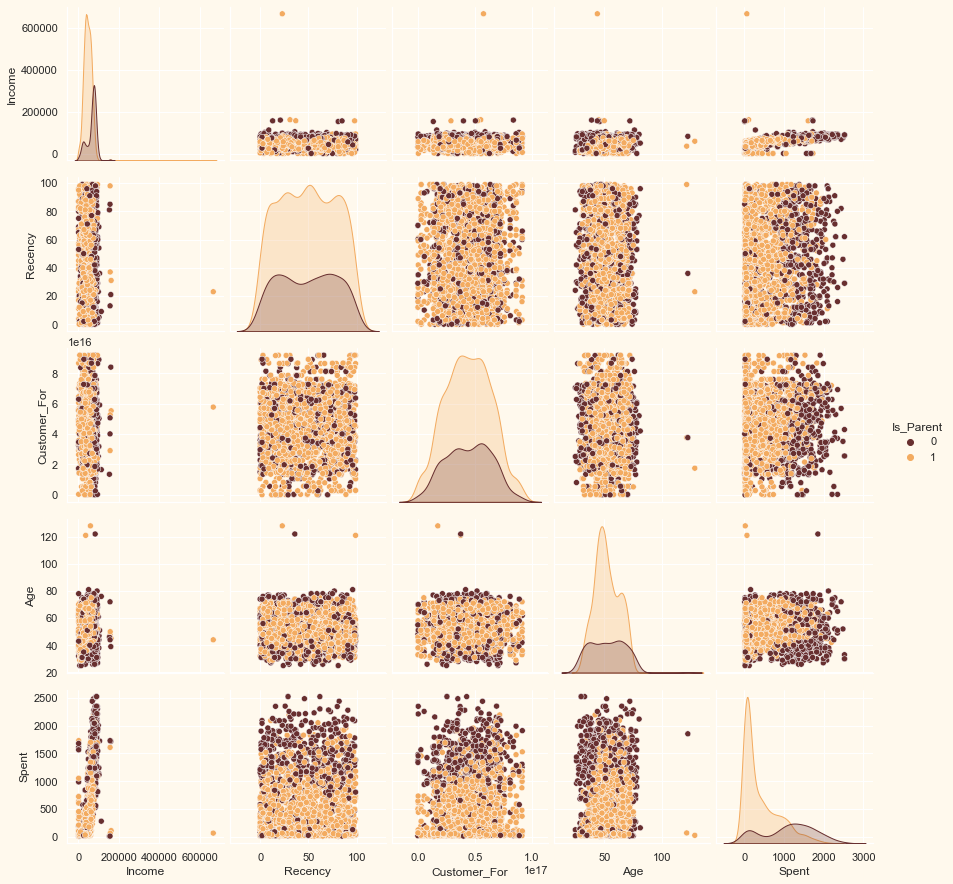

In [17]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure(figsize=(20,20))
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

Clearly, there are a few outliers in the Income and Age features. Let's delete the outliers in the data.

In [18]:
#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2236


Next, let us look at the correlation amongst the features. (Excluding the categorical attributes at this point)

<AxesSubplot:>

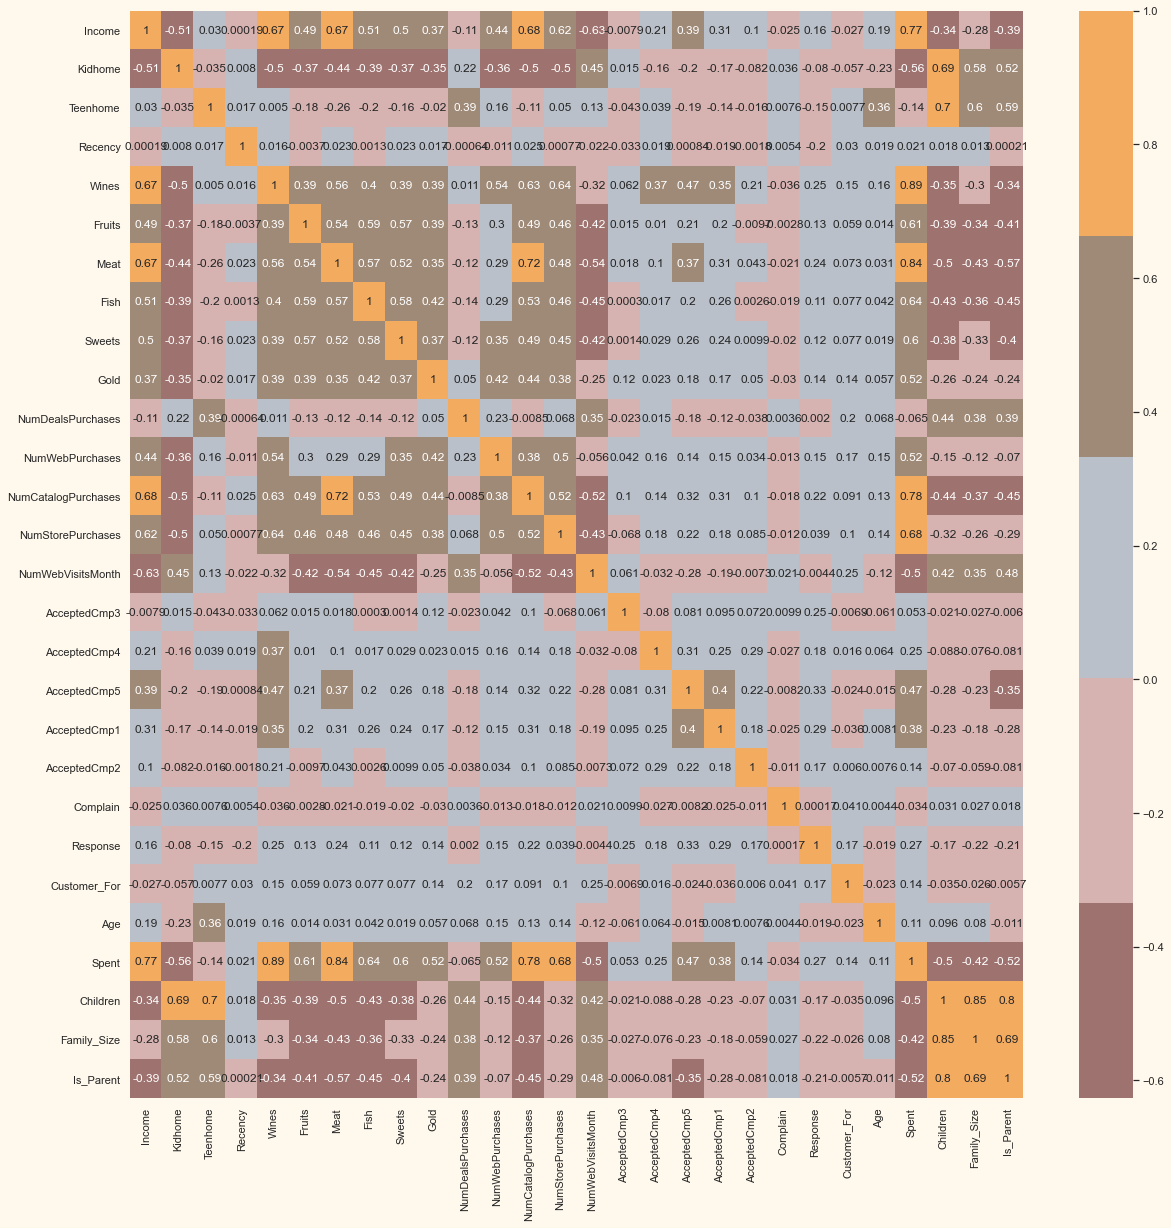

In [19]:
#correlation matrix
corrmat= df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

The data is quite clean and the new features have been included. Let's proceed to the next step. That is, preprocessing the data.

## Data Preprocessing

The preprocessing steps for performing clustering operations are:
- Label encoding the categorical features
- Scaling the features using the standard scaler
- Creating a subset dataframe for dimensionality reduction


In [20]:
#Get list of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Marital_Status']


In [21]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [22]:
#Creating a copy of data
ds = df.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions - as they contain few observations
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

In [25]:
ds.dtypes

Education                       int32
Marital_Status                  int32
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
Wines                           int64
Fruits                          int64
Meat                            int64
Fish                            int64
Sweets                          int64
Gold                            int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
Customer_For                    int64
Age                             int64
Spent                           int64
Children                        int64
Family_Size                     int64
Is_Parent                       int32
dtype: object

In [26]:
# Delete Dt_customer
ds.drop('Dt_Customer', axis=1, inplace=True)

In [29]:
# Scaling

scale = StandardScaler().fit_transform(ds.values)
scaled_ds = pd.DataFrame(scale, index=ds.index, columns=ds.columns)

print("All features are now scaled")

All features are now scaled


In [30]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
0,-0.89438,1.347635,0.305017,-0.824939,-0.930615,0.306856,0.983228,1.554170,1.679746,2.461068,...,1.407639,2.509801,-0.552429,0.692865,1.975467,1.016868,1.680176,-1.264308,-1.758810,-1.584362
1,-0.89438,1.347635,-0.230644,1.032627,0.905974,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,...,-1.110921,-0.568970,-1.167738,-0.131421,-1.667017,1.273264,-0.962202,1.395139,0.445618,0.631169
2,-0.89438,-0.742041,0.917025,-0.824939,-0.930615,-0.798467,0.362159,0.572177,-0.177201,1.344595,...,1.407639,-0.226884,1.293496,-0.543564,-0.172996,0.333146,0.282541,-1.264308,-0.656596,-1.584362
3,-0.89438,-0.742041,-1.125289,1.032627,-0.930615,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,...,-0.751127,-0.911056,-0.552429,0.280722,-1.925349,-1.290693,-0.918994,0.065416,0.445618,0.631169
4,0.57070,-0.742041,0.312057,1.032627,-0.930615,1.550344,-0.389661,0.421101,-0.217088,0.154911,...,0.328256,0.115201,0.062879,-0.131421,-0.823131,-1.034298,-0.305762,0.065416,0.445618,0.631169


## Dimensionality reduction

In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why we will be performing dimensionality reduction on the selected features before putting them through a classifier.
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss
We will apply PCA to our dataset and plot the reduced dataframe


In [31]:
#Initiating PCA to reduce dimentions aka features to 3

pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2236.0,-2.063545e-16,2.869052,-5.938221,-2.519117,-0.779979,2.365167,7.442893
col2,2236.0,1.388275e-16,1.705098,-4.305230,-1.328156,-0.157422,1.235988,6.113399
col3,2236.0,-1.206548e-17,1.218564,-3.472103,-0.813788,-0.026444,0.797764,6.538208


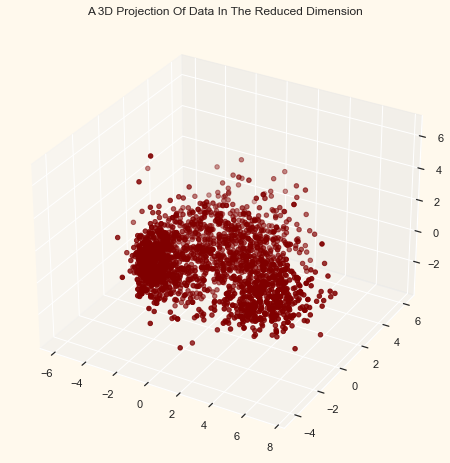

In [32]:
#A 3D Projection Of Data In The Reduced Dimension

x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Clustering

Now that I have reduced the attributes to three dimensions,we will be performing clustering via a hierarchical clustering method. It involves merging examples until the desired number of clusters is achieved.

Steps involved in the Clustering
- Elbow Method to determine the number of clusters to be formed
- Clustering via Agglomerative Clustering
- Examining the clusters formed via scatter plot


### Determining the cluster number
- There are many methods and metrics to determine the cluster number e.g the classic elbow method. 
- The yellowbrick libraries is an important method and have many interesting metrics to help determine cluster number

By default, the scoring parameter metric is set to distortion, which computes the sum of squared distances from each point to its assigned center. 
However, two other metrics can also be used with the KElbowVisualizer – silhouette and calinski_harabasz. 
The silhouette score calculates the mean Silhouette Coefficient of all samples, while the calinski_harabasz score computes the ratio of dispersion between and within clusters. We will go through all the metrics and comapre.

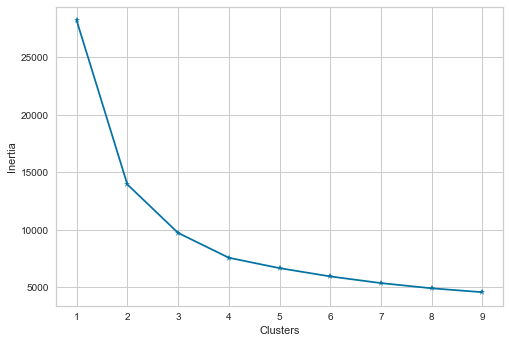

In [41]:
# Classic elbow method

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
inertia = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 50)
    kmeans.fit(PCA_ds)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 10), inertia,marker = '*')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

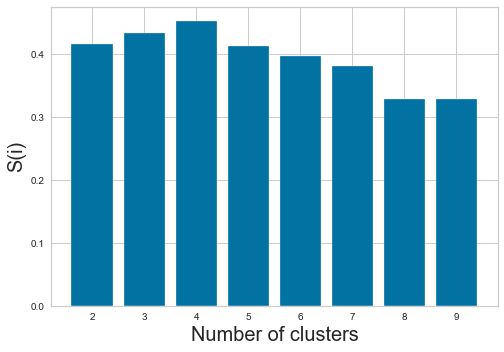

In [73]:
# We see it is not clear which cluster to choose 
# Let's calculate the silhouette score : higher silhouette score for the cluster is the target 
from sklearn.metrics import silhouette_score 

silhouette_scores = []
for i in range(2,10):
    m1=KMeans(n_clusters=i, random_state=42)
    c = m1.fit_predict(PCA_ds)
    silhouette_scores.append(silhouette_score(PCA_ds, m1.fit_predict(PCA_ds))) 
plt.bar(range(2,10), silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

In [74]:
# Getting the maximum value of silhouette score and adding 2 in index because index starts from 2.

sc=max(silhouette_scores)
number_of_clusters=silhouette_scores.index(sc)+2
print("Number of Cluster Required is : ", number_of_clusters)

Number of Cluster Required is :  4


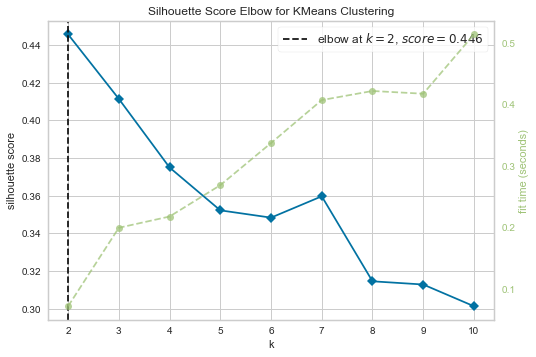

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [42]:
# using yellowbrick method and silhouette metrics

from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(init = 'k-means++'), k=10, metric='silhouette')
Elbow_M.fit(PCA_ds)
Elbow_M.show()

Elbow Method to determine the number of clusters to be formed:


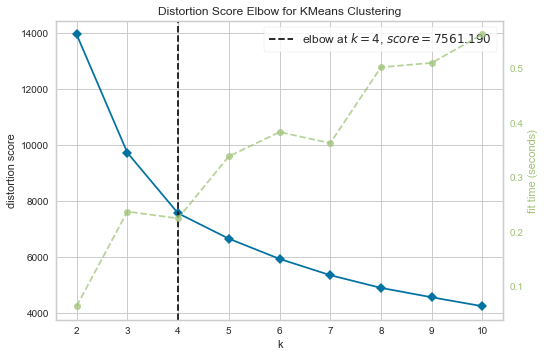

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
# Elbow method with distortion metrics - distortion is the default method

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(init = 'k-means++'), k=10, metric='distortion')
#Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

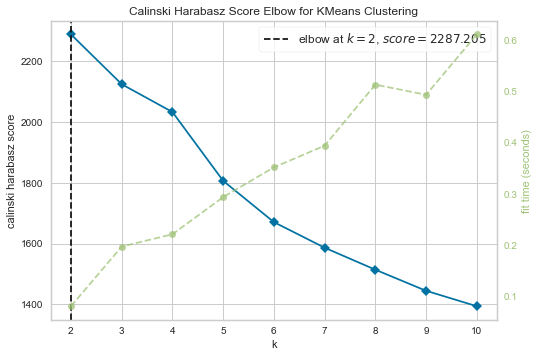

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [45]:
# Determining cluster number by using calinski_harabasz metric
Elbow_M = KElbowVisualizer(KMeans(init = 'k-means++'), k=10, metric='calinski_harabasz')
Elbow_M.fit(PCA_ds)
Elbow_M.show()

So based on the different metrics, number of clusters selected are :
- Intertia - 3 (Selected based on the plot)
- Silhouette - 2
- Distortion - 4,5,6,7 (varies alot with the random initialisation of clusters)
- Calinski Harabasz -2

We will proceed with 4.

### Model building

In [59]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe
df["Clusters"]= yhat_AC

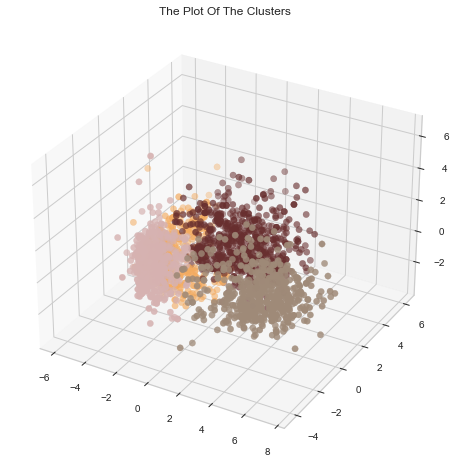

In [60]:
# To examine the clusters formed let's have a look at the 3-D distribution of the clusters

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

### Model evaluation

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. 
The purpose is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

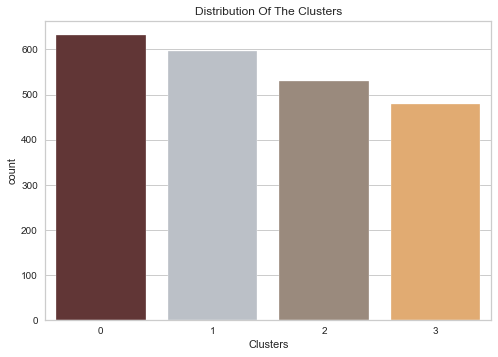

In [63]:
# Firstly, let us have a look at the group distribution of clustring

#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

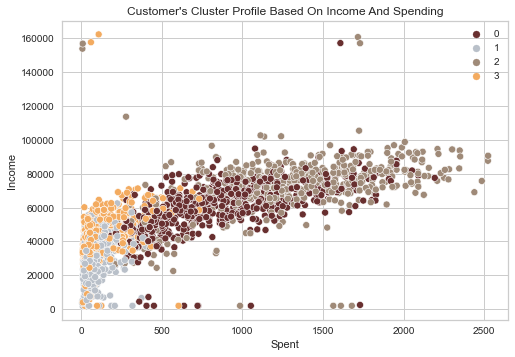

In [71]:
# Plotting the cluster
SAVING_DIR = r'D:\Marketing_Analytics\visualizations'

pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["Clusters"], palette= pal)
pl.set_title("Customer's Cluster Profile Based On Income And Spending")
plt.legend()

# Saving the figure

my_path = SAVING_DIR
my_file = 'customer_cluster.png'
plt.savefig(os.path.join(my_path, my_file))
#figure.savefig('heatmap_correlation_matrix.png')
#plt.show()
plt.show()

Income vs spending plot shows the clusters pattern
- group 0: high spending & average income
- group 1: low spending & low income
- group 2: high spending & high income
- group 3: low spending & average income

Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold


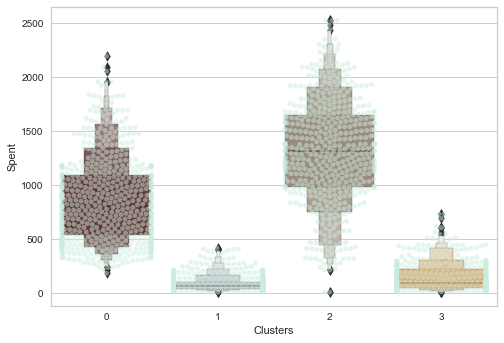

In [65]:
plt.figure()
pl=sns.swarmplot(x=df["Clusters"], y=df["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["Spent"], palette=pal)
plt.show()

From the above plot, it can be clearly seen that cluster 2 is our biggest set of customers closely followed by cluster 0. We can explore what each cluster is spending on for the targeted marketing strategies.

Let us next explore how did our campaigns do in the past.


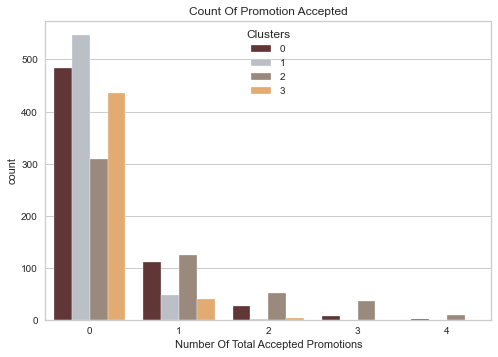

In [66]:
#Creating a feature to get a sum of accepted promotions 
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

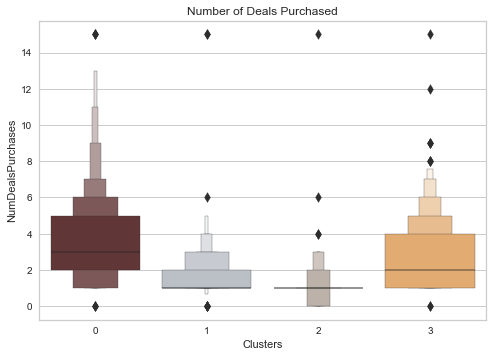

In [67]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df["NumDealsPurchases"],x=df["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. However, our star customers cluster 2 are not much into the deals. Nothing seems to attract cluster 1 overwhelmingly

## Profiling

Now that we have formed the clusters and looked at their purchasing habits. Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. On the basis of the outcomes, I will be arriving at the conclusions.

<Figure size 576x396 with 0 Axes>

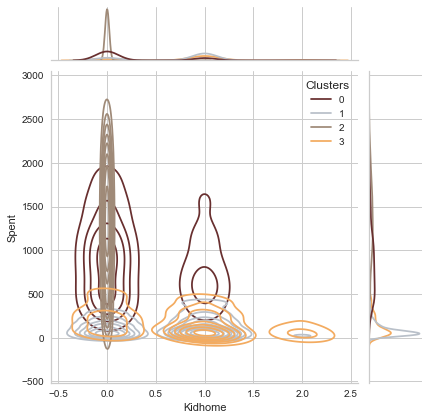

<Figure size 576x396 with 0 Axes>

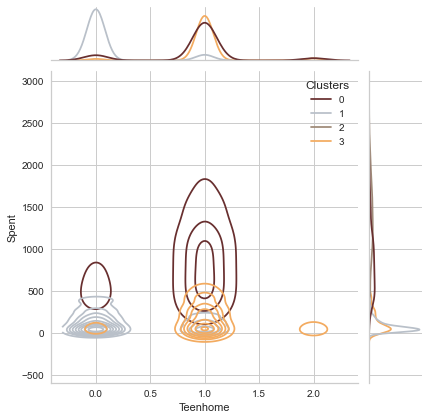

<Figure size 576x396 with 0 Axes>

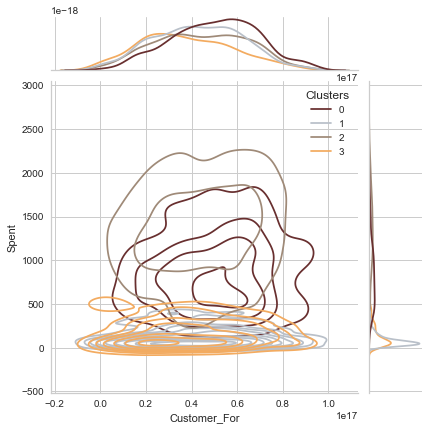

<Figure size 576x396 with 0 Axes>

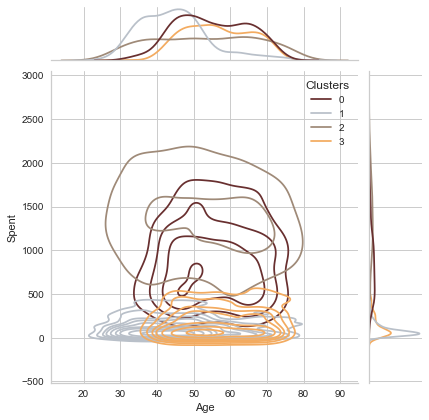

<Figure size 576x396 with 0 Axes>

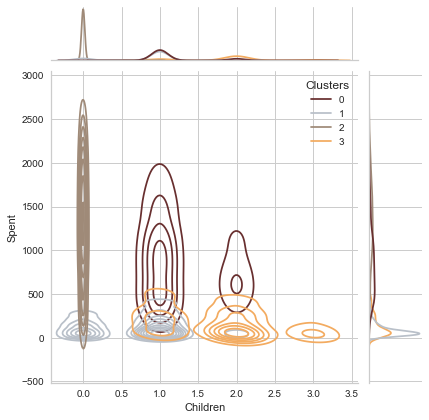

<Figure size 576x396 with 0 Axes>

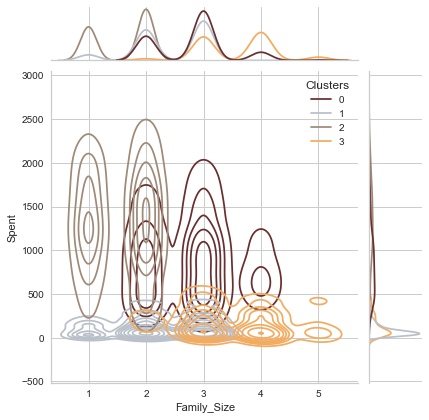

<Figure size 576x396 with 0 Axes>

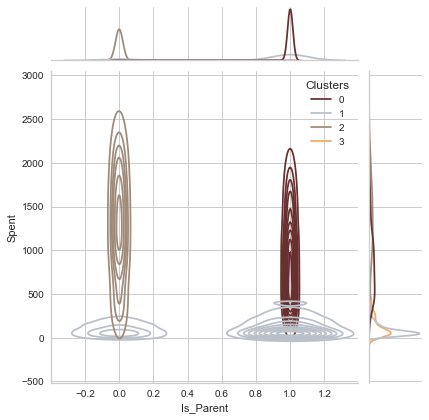

<Figure size 576x396 with 0 Axes>

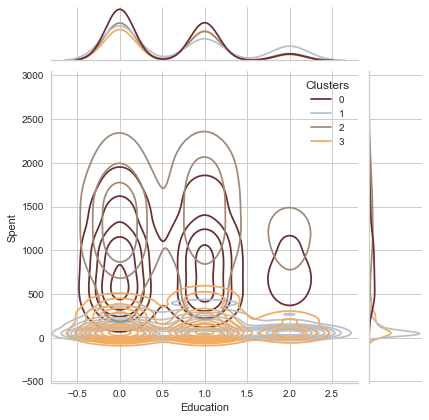

<Figure size 576x396 with 0 Axes>

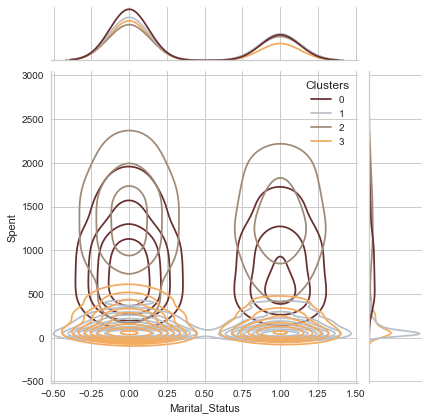

In [70]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Marital_Status"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Spent"], hue =df["Clusters"], kind="kde", palette=pal)
    plt.show()

The following information can be deduced about the customers in different clusters
#### Culster -0
- They are definitely a parent
- At the max are 5 members in the family and at least 2
- Mjority of them have a teenager at home
- Relatively oder
- A lower-income group
#### cluster -1
- Are a definetly parent
- At the max have 4 members in the fiamily and at least 2
- Single parents are a subset of this group
- Most hava a teenager at home
- Relatively older
#### Culster -2
- Are a definitely not a parent
- At the max only 2 members in the family
- A slight majority of couples over single people
- Sapan over all ages
- A high income group
#### Cluster - 3
- The mjority of these people are parents
- At the max are 3 members in the family
- They majorly have one kid
- Relatively youner


## Conclusion

In this project, I performed unsupervised clustering. I did use dimensionality reduction followed by agglomerative clustering. I came up with 4 clusters and further used them in profiling customers in clusters according to their family structures and income/spending. This can be used in planning better marketing strategies.